# Plots for `Madam Iqra` 

In [ ]:
"""
germination_plot_fixed.py
Plots germination (%) data grouped by temperature and incubation time.
Automatically detects column names and handles multiple species.
Run: python germination_plot_fixed.py
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches

# === 1. Load the data ===
# === 1. Load the data ===
df = pd.read_excel("./germination_dummy.xlsx")




TypeError: arg must be a list, tuple, 1-d array, or Series


Detected columns:
  Species      -> Species
  Temperature  -> Temperature_C
  Time         -> Time
  Germination  -> Germination_%
  SE           -> SE

After renaming, columns are: ['Species', 'Temperature_C', 'Incubation_h', 'Germination_%', 'SE', 'Unnamed: 5']

Sample data for Temperature_C:
0    10
1    10
2    10
3    10
4    10
5    10
6    15
7    15
8    15
9    15
Name: Temperature_C, dtype: object

Sample data for Incubation_h:
0     6.0
1    12.0
2    18.0
3    24.0
4    36.0
5    48.0
6     6.0
7    12.0
8    18.0
9    24.0
Name: Incubation_h, dtype: float64

Sample data for Germination_%:
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    4
Name: Germination_%, dtype: object

Sample data for SE:
0           0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9    0.417436
Name: SE, dtype: object
✅ Saved plot to: D:\04 L1 Python_Ka_Chila\Data_Science_Ammar\germination_plot_fixed.png


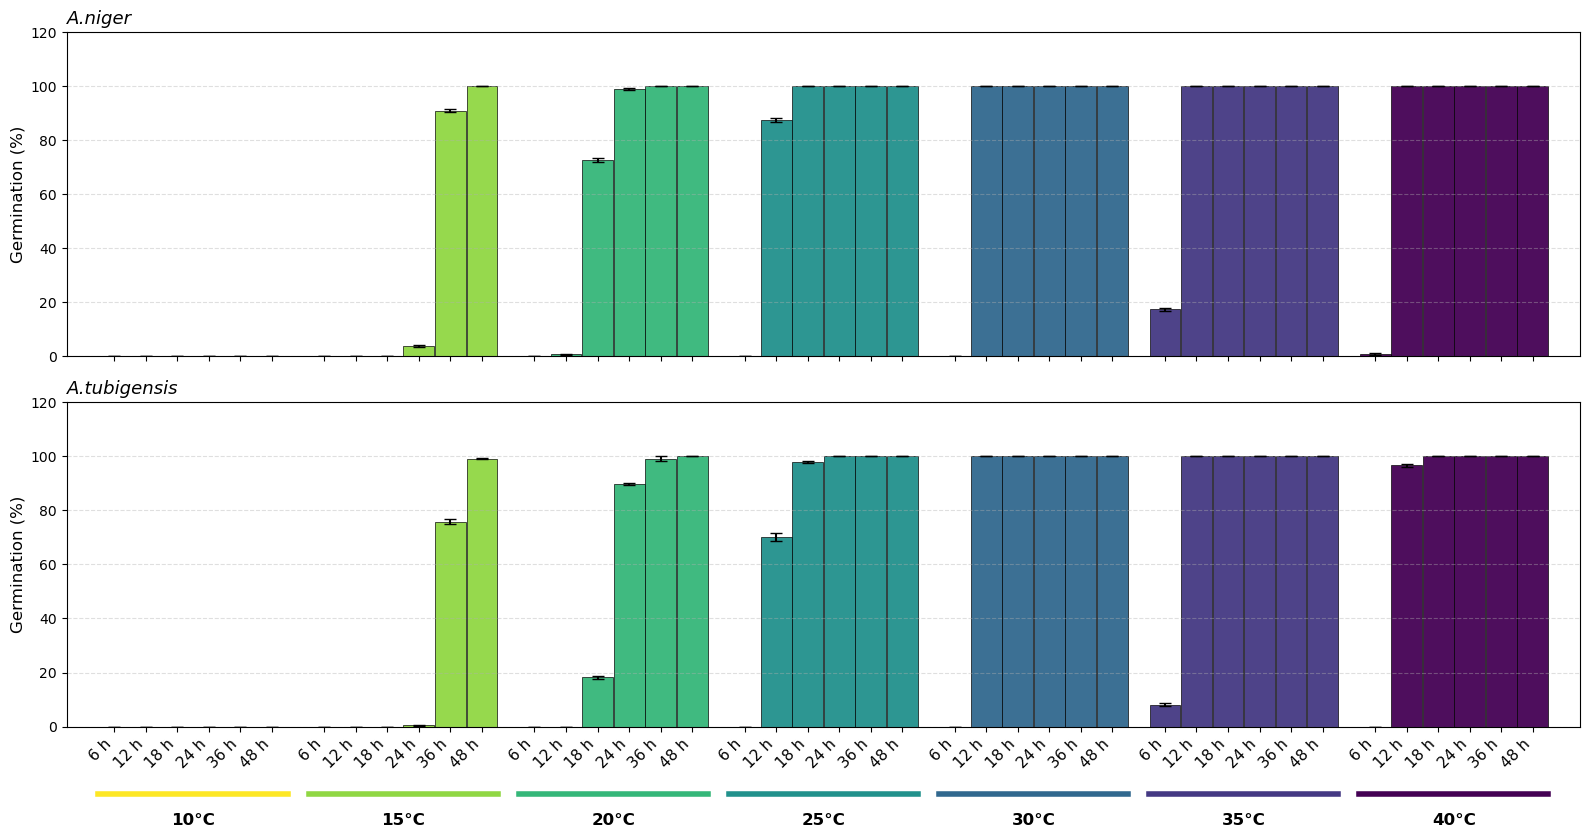

In [28]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches


# === 1. Load the data ===
df = pd.read_excel("./germination_dummy.xlsx")


# === 2. Auto-detect column names ===
def find_col(df_cols, keywords, exclude=None):
    for col in df_cols:
        low = col.lower()
        if exclude and col == exclude:
            continue
        for kw in keywords:
            if kw in low:
                return col
    return None


# Try not to map two names to the same column!
col_species = find_col(df.columns, ["species", "genotype", "strain", "sample"])
col_temp = find_col(df.columns, ["temperature", "temp", "°c", "c"], exclude=col_species)
col_time = find_col(df.columns, ["incubation", "time", "hours", "hour", "h"])
col_value = find_col(df.columns, ["germination", "germination_%", "germination%", "germination rate"])
col_se = find_col(df.columns, ["se", "std", "stderr", "std_err", "stderror", "standard_error"])


print("\nDetected columns:")
print(f"  Species      -> {col_species}")
print(f"  Temperature  -> {col_temp}")
print(f"  Time         -> {col_time}")
print(f"  Germination  -> {col_value}")
print(f"  SE           -> {col_se}")


# Additional robust check for two columns mapped to the same header
mapped_cols = [col_species, col_temp, col_time, col_value, col_se]
if len(set(filter(None, mapped_cols))) != len(list(filter(None, mapped_cols))):
    print("\nERROR: At least two required field names map to the same column! Fix your spreadsheet header names.")
    print("Available columns: ", list(df.columns))
    import sys
    sys.exit(1)


# Fail if key columns missing
missing = []
if col_species is None: missing.append("Species (e.g. 'Species')")
if col_temp is None: missing.append("Temperature (e.g. 'Temperature_C')")
if col_time is None: missing.append("Time (e.g. 'Incubation_h')")
if col_value is None: missing.append("Germination (e.g. 'Germination_%')")
if missing:
    print(f"\nERROR: Missing columns: {', '.join(missing)}. Available columns: {', '.join(df.columns)}")
    import sys
    sys.exit(1)


if col_se is None:
    df["SE"] = 0.0
    col_se = "SE"


# === 3. Rename standardized columns ===
rename_map = {
    k: v for k, v in [
        (col_species, "Species"),
        (col_temp, "Temperature_C"),
        (col_time, "Incubation_h"),
        (col_value, "Germination_%"),
        (col_se, "SE"),
    ] if k is not None
}
df = df.rename(columns=rename_map)
print("\nAfter renaming, columns are:", list(df.columns))


# === 4. Clean up data ===
numeric_cols = ["Temperature_C", "Incubation_h", "Germination_%", "SE"]
for col in numeric_cols:
    if col in df.columns:
        sample = df[col].head(10)
        print(f"\nSample data for {col}:")
        print(sample)
        if pd.to_numeric(sample, errors="coerce").notna().all():
            df[col] = pd.to_numeric(df[col], errors="coerce")
        else:
            print(f"⚠️ Column '{col}' is not fully numeric. Check mapping/source file.")


# Robust dropna for only available columns
required_cols = ["Species", "Temperature_C", "Incubation_h", "Germination_%"]
final_subset = [col for col in required_cols if col in df.columns]
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"\nWARNING: Cannot dropna by missing columns: {missing_cols}")
    import sys
    sys.exit(1)
df = df.dropna(subset=final_subset).reset_index(drop=True)


# Final existence check before plotting
for col in required_cols:
    if col not in df.columns:
        print(f"\nERROR: Column '{col}' missing for plotting. Available columns: {list(df.columns)}")
        import sys
        sys.exit(1)


# === 5. Group info ===
species_list = sorted(df["Species"].unique().tolist())
temps = np.sort(df["Temperature_C"].unique())
times = np.sort(df["Incubation_h"].unique())


MAX_TEMP_GROUPS = 7
if len(temps) > MAX_TEMP_GROUPS:
    print(f"Limiting temperatures to {MAX_TEMP_GROUPS} lowest.")
    temps = temps[:MAX_TEMP_GROUPS]


# === 6. Plot setup ===
group_centers = np.arange(len(temps))
bar_group_width = 0.9
width = bar_group_width / max(1, len(times))
offsets = (np.arange(len(times)) - (len(times) - 1) / 2.0) * width


fig, axes = plt.subplots(len(species_list), 1, figsize=(16, 4.2 * len(species_list)), sharex=True, sharey=True)
if len(species_list) == 1:
    axes = [axes]


# REVERSED COLOR PALETTE: yellow to blue
cmap = plt.get_cmap("viridis")
temp_colors = [cmap(i) for i in np.linspace(1, 0, len(temps))]


# === 7. Plotting ===
for ax, sp in zip(axes, species_list):
    subset = df[df["Species"] == sp].copy()


    val_matrix = np.zeros((len(temps), len(times)))
    se_matrix = np.zeros((len(temps), len(times)))


    for i, temp in enumerate(temps):
        for j, t in enumerate(times):
            sel = subset.query("Temperature_C == @temp and Incubation_h == @t")
            val_matrix[i, j] = sel["Germination_%"].mean() if not sel.empty else 0.0
            se_matrix[i, j] = sel["SE"].mean() if not sel.empty else 0.0


    # Plot bars
    for i in range(len(temps)):
        for j in range(len(times)):
            pos = group_centers[i] + offsets[j]
            ax.bar(
                pos,
                val_matrix[i, j],
                width=width * 0.98,
                color=temp_colors[i],
                yerr=se_matrix[i, j],
                capsize=4,
                edgecolor="black",
                linewidth=0.5,
                alpha=0.95,
            )


    ax.set_ylim(0, 120)
    ax.set_ylabel("Germination (%)", fontsize=12)
    ax.set_title(sp, loc="left", fontstyle="italic", fontsize=13)
    ax.grid(axis="y", linestyle="--", alpha=0.4)


# === 8. Axis formatting ===
positions_matrix = (group_centers.reshape(-1, 1) + offsets.reshape(1, -1))
bottom_ticks = positions_matrix.flatten()
bottom_labels = [f"{int(t)} h" for _ in range(len(temps)) for t in times]


axes[-1].set_xticks(bottom_ticks)
axes[-1].set_xticklabels(bottom_labels, rotation=45, ha="right", fontsize=11)
axes[-1].set_xlim(group_centers[0] - 0.6, group_centers[-1] + 0.6)


# Add horizontal lines and temperature labels beneath each group (more spacing)
for i, temp in enumerate(temps):
    # Calculate the left and right boundaries of each temperature group
    left_bound = group_centers[i] - bar_group_width / 2
    right_bound = group_centers[i] + bar_group_width / 2
    
    # Draw horizontal line below the x-axis (moved further down)
    axes[-1].plot([left_bound, right_bound], [-25, -25], 
                  color=temp_colors[i], linewidth=4, clip_on=False)
    
    # Add temperature label centered below the line (moved further down)
    axes[-1].text(group_centers[i], -32, f"{int(temp)}°C", 
                  ha="center", va="top", fontsize=12, fontweight='bold')


plt.tight_layout()


# === 9. Save & Show ===
__file__ = "D:\\04 L1 Python_Ka_Chila\\Data_Science_Ammar\\Madam_Iqra"
out_path = Path(__file__).parent / "germination_plot_fixed.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"✅ Saved plot to: {out_path}")


plt.show()
